In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [ ]:
df_orders = pd.read_csv("food_delivery_data.csv")  # Dataset 1
df_demographics = pd.read_csv("food_delivery_data_with_demographics.csv")  # Dataset 2
df_food_type = pd.read_csv("food_delivery_data_with_food_type.csv")  # Dataset 3
#df_orders["OrderDate"] = pd.to_datetime(df["OrderDate"])

In [ ]:
# Check for missing values in each dataset
print("Missing Values in Orders Dataset:\n", df_orders.isnull().sum(), "\n")
print("Missing Values in Demographics Dataset:\n", df_demographics.isnull().sum(), "\n")
print("Missing Values in Food Type Dataset:\n", df_food_type.isnull().sum(), "\n")

# Check for duplicates
print("Duplicate Orders:", df_orders.duplicated().sum())
print("Duplicate Demographics:", df_demographics.duplicated().sum())
print("Duplicate Food Type:", df_food_type.duplicated().sum())

Missing Values in Orders Dataset:
 OrderID               0
CustomerID            0
OrderDate             0
DeliveryDistanceKM    0
OrderAmount           0
DiscountApplied       0
DeliveryTimeMin       0
dtype: int64 

Missing Values in Demographics Dataset:
 OrderID       0
CustomerID    0
OrderDate     0
Age           0
Gender        0
City          0
dtype: int64 

Missing Values in Food Type Dataset:
 OrderID       0
CustomerID    0
OrderDate     0
FoodType      0
dtype: int64 

Duplicate Orders: 0
Duplicate Demographics: 0
Duplicate Food Type: 0


In [ ]:
df_orders["OrderDate"] = pd.to_datetime(df_orders["OrderDate"])
df_orders["OrderAmount"] = df_orders["OrderAmount"].replace('[\$,]', '', regex=True).astype(float)
# Remove "%" and convert to float



# Summary statistics
print(df_orders.describe())




           OrderID  CustomerID                   OrderDate  \
count   500.000000  500.000000                         500   
mean   5465.224000  557.098000  2024-11-25 07:29:16.800000   
min    1019.000000  100.000000         2024-10-12 00:00:00   
25%    3122.250000  336.750000         2024-11-03 00:00:00   
50%    5499.000000  543.500000         2024-11-24 12:00:00   
75%    7663.500000  770.500000         2024-12-18 00:00:00   
max    9999.000000  999.000000         2025-01-10 00:00:00   
std    2627.775576  259.839746                         NaN   

       DeliveryDistanceKM  OrderAmount  DiscountApplied  DeliveryTimeMin  
count           500.00000   500.000000       500.000000       500.000000  
mean             10.56950    54.468080         7.587060        34.754000  
min               1.00000    10.140000         0.000000        10.000000  
25%               5.93250    29.760000         3.757500        24.000000  
50%              10.71500    55.720000         7.840000        34.

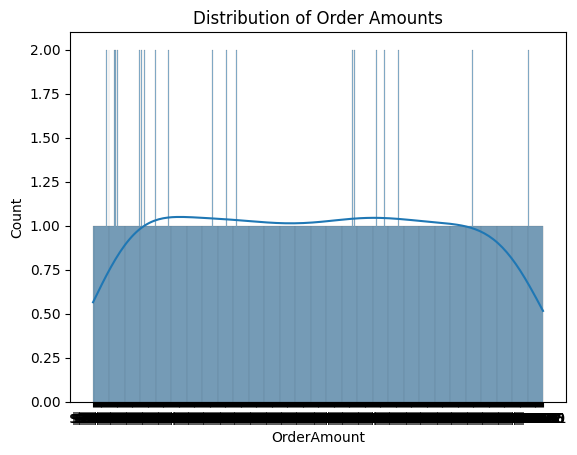

In [ ]:
# Distribution of order amounts
sns.histplot(df_orders["OrderAmount"], bins=30, kde=True)
plt.title("Distribution of Order Amounts")
plt.show()

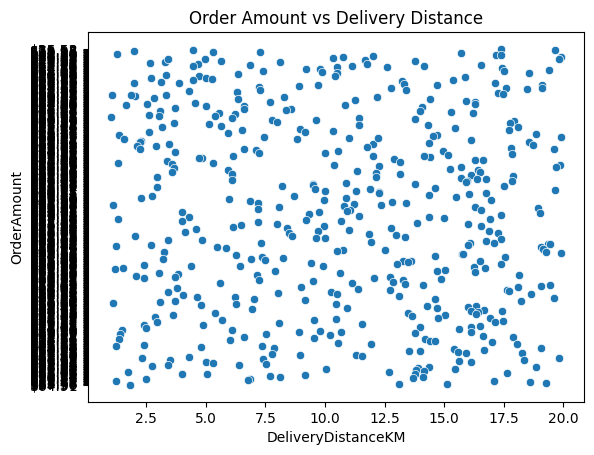

In [ ]:
sns.scatterplot(x=df_orders["DeliveryDistanceKM"], y=df_orders["OrderAmount"])
plt.title("Order Amount vs Delivery Distance")
plt.show()

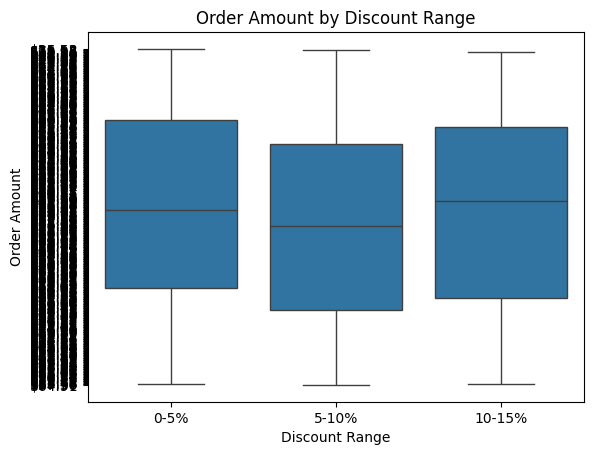

In [ ]:
# Create discount bins
df_orders["DiscountRange"] = pd.cut(df_orders["DiscountApplied"], bins=[0, 5, 10, 15], labels=["0-5%", "5-10%", "10-15%"])

# Plot order amount vs discount range
sns.boxplot(x=df_orders["DiscountRange"], y=df_orders["OrderAmount"])
plt.title("Order Amount by Discount Range")
plt.xlabel("Discount Range")
plt.ylabel("Order Amount")
plt.show()


In [ ]:

corr = df_orders[["DiscountApplied", "OrderAmount"]].corr()
print(corr)
print("This shows theres not much correlation between discount applied and order of the amount")


                 DiscountApplied  OrderAmount
DiscountApplied         1.000000    -0.027121
OrderAmount            -0.027121     1.000000
This shows theres not much correlation between discount applied and order of the amount


In [ ]:
print(df_orders.dtypes)


OrderID                        int64
CustomerID                     int64
OrderDate             datetime64[ns]
DeliveryDistanceKM           float64
OrderAmount                  float64
DiscountApplied              float64
DeliveryTimeMin                int64
DiscountRange               category
dtype: object


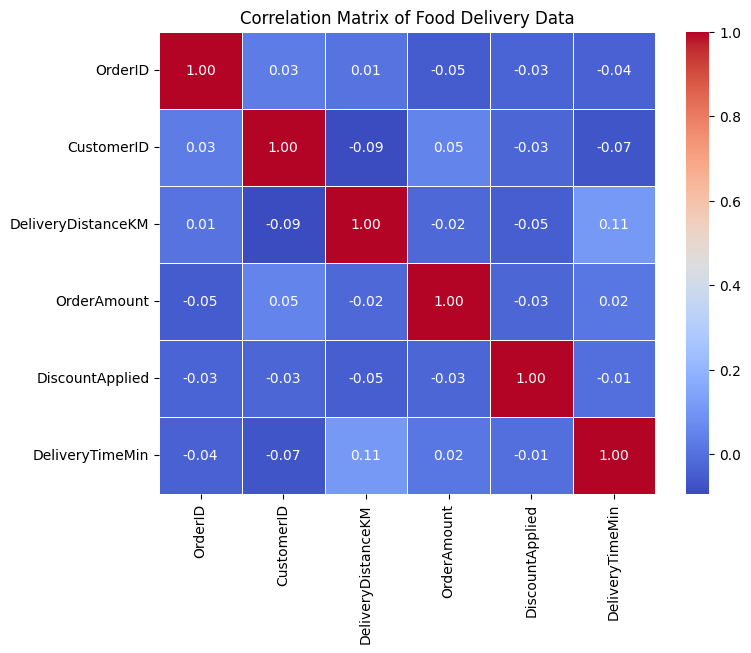

In [ ]:
# Drop categorical columns
df_corr = df_orders.drop(columns=["OrderDate", "DiscountRange"])

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Food Delivery Data")
plt.show()


In [ ]:
OrderID	CustomerID	OrderDate	DeliveryDistanceKM	OrderAmount	DiscountApplied	DeliveryTimeMin

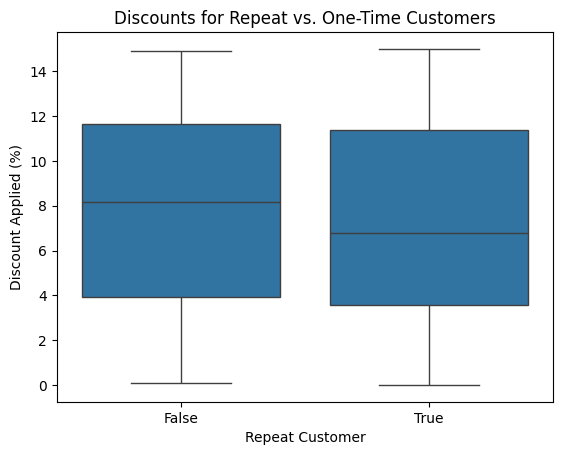

In [ ]:
# Count the number of orders per customer
customer_orders = df_orders.groupby("CustomerID")["OrderID"].count().reset_index()
customer_orders.columns = ["CustomerID", "OrderCount"]

# Define repeat customers (ordered more than once)
customer_orders["IsRepeatCustomer"] = customer_orders["OrderCount"] > 1

# Merge this back with the original orders dataset
df_orders = df_orders.merge(customer_orders, on="CustomerID", how="left")


# Compare discount applied for repeat vs. one-time customers
sns.boxplot(x=df_orders["IsRepeatCustomer"], y=df_orders["DiscountApplied"])
plt.title("Discounts for Repeat vs. One-Time Customers")
plt.xlabel("Repeat Customer")
plt.ylabel("Discount Applied (%)")
plt.show()


<ipython-input-51-cfba90999ea7>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_rate = df_orders.groupby("DiscountCategory")["IsRepeatCustomer"].mean()


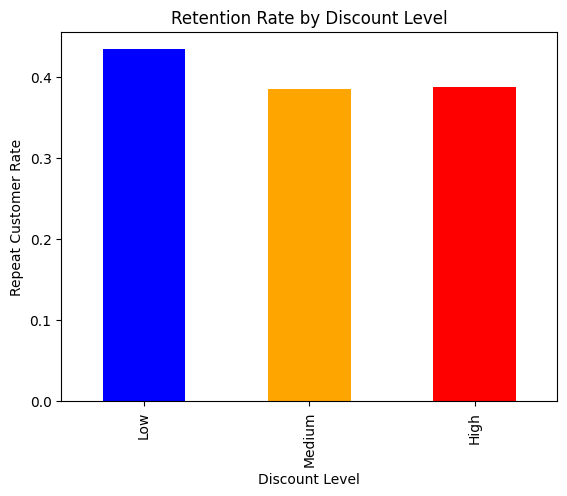

In [ ]:

# Define discount categories (low = 0-5%, medium = 5-10%, high = 10-15%)
df_orders["DiscountCategory"] = pd.cut(df_orders["DiscountApplied"], bins=[0, 5, 10, 15], labels=["Low", "Medium", "High"])

# Calculate retention rate for each discount category
retention_rate = df_orders.groupby("DiscountCategory")["IsRepeatCustomer"].mean()

# Plot the retention rate
retention_rate.plot(kind="bar", color=["blue", "orange", "red"])
plt.title("Retention Rate by Discount Level")
plt.xlabel("Discount Level")
plt.ylabel("Repeat Customer Rate")
plt.show()


In [ ]:
# Convert IsRepeatCustomer (True/False) to numeric (1/0)
df_orders["IsRepeatCustomer"] = df_orders["IsRepeatCustomer"].astype(int)

# Check correlation with repeat customer status
corr = df_orders[["IsRepeatCustomer", "DeliveryDistanceKM", "DeliveryTimeMin", "OrderAmount"]].corr()

# Print correlation matrix
print(corr["IsRepeatCustomer"])


NameError: name 'df_orders' is not defined

###### DEMOGRAPHICS DATA ANALAYSIS

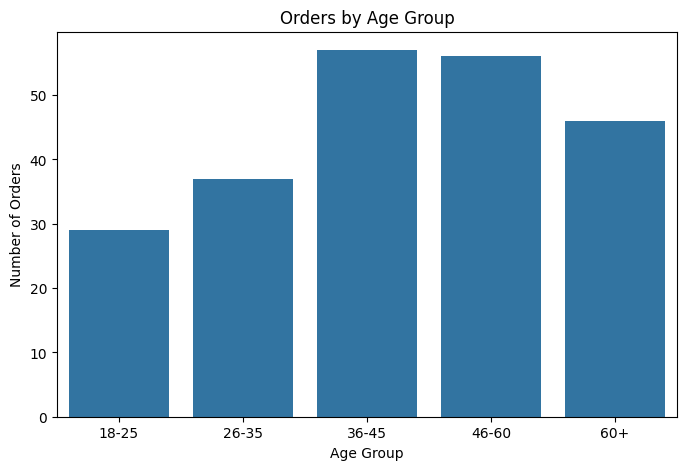

In [ ]:
# Create age groups
bins = [18, 25, 35, 45, 60, 100]
labels = ["18-25", "26-35", "36-45", "46-60", "60+"]
df_demographics["AgeGroup"] = pd.cut(df_demographics["Age"], bins=bins, labels=labels, right=False)

# Count orders by age group
age_orders = df_demographics["AgeGroup"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=age_orders.index, y=age_orders.values)
plt.title("Orders by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Orders")
plt.show()


In [ ]:
# Count how many times each customer has ordered
repeat_customers = df_demographics["CustomerID"].value_counts()

# Create a new column to mark repeat customers (1 = Repeat, 0 = One-time)
df_demographics["IsRepeatCustomer"] = df_demographics["CustomerID"].apply(lambda x: 1 if repeat_customers[x] > 1 else 0)


# Convert categorical variables to numeric for correlation
df_demographics["Gender"] = df_demographics["Gender"].astype("category").cat.codes  # Male=0, Female=1
df_demographics["City"] = df_demographics["City"].astype("category").cat.codes  # Assign numeric values to cities

# Compute correlation
corr = df_demographics[["IsRepeatCustomer", "Age", "Gender", "City"]].corr()

# Print correlation with repeat customers
print(corr["IsRepeatCustomer"])


IsRepeatCustomer    1.000000
Age                 0.080352
Gender             -0.057638
City               -0.068578
Name: IsRepeatCustomer, dtype: float64


In [ ]:
print(df_orders["CustomerID"].nunique(), len(df_orders))



389 500


In [ ]:
repeat_customers = df_orders["CustomerID"].value_counts()
num_repeat_customers = (repeat_customers > 1).sum()

print(f"Total Repeat Customers: {num_repeat_customers}")


Total Repeat Customers: 91


In [ ]:
df_food_type["FoodType"].value_counts()


,count
FoodType,
Dessert,67
Seafood,58
Pasta,57
Sandwich,52
Sushi,51
Tacos,51
Pizza,51
Salad,42
Steak,40


In [ ]:
df_merged = df_food_type.merge(df_orders[["OrderID", "IsRepeatCustomer"]], on="OrderID", how="left")
df_merged.groupby("FoodType")["IsRepeatCustomer"].mean().sort_values(ascending=False)


,IsRepeatCustomer
FoodType,
Dessert,1.00
Steak,1.00
Pasta,0.75
Seafood,0.60
Burger,0.50
Sandwich,0.50
Tacos,0.25
Pizza,0.00
Salad,NaN


In [ ]:
df_merged = df_food_type.merge(df_demographics, on="OrderID", how="left")
df_merged.groupby(["FoodType", "Gender"])["OrderID"].count().unstack()


Gender,0.0,1.0,2.0
FoodType,,,
Burger,9,5,2
Dessert,16,9,9
Pasta,11,7,9
Pizza,8,10,5
Salad,9,4,7
Sandwich,5,8,7
Seafood,11,8,9
Steak,9,6,4
Sushi,8,6,6


In [ ]:
df_merged.groupby(["FoodType", "City"])["OrderID"].count().unstack()


City,0.0,1.0,2.0,3.0
FoodType,,,,
Burger,3,6,5,2
Dessert,6,10,8,10
Pasta,5,9,4,9
Pizza,10,6,2,5
Salad,6,7,4,3
Sandwich,2,8,8,2
Seafood,7,8,10,3
Steak,3,6,4,6
Sushi,5,7,4,4


In [ ]:
df_pivot = df_merged.groupby(["City", "FoodType"])["OrderAmount"].mean().unstack()
df_pivot.fillna(0, inplace=True)  # Replace NaNs with 0
df_pivot


FoodType,Burger,Dessert,Pasta,Pizza,Salad,Sandwich,Seafood,Steak,Sushi,Tacos
City,,,,,,,,,,
0.0,0.00,0.0,0.0,26.39,0.0,0.0,81.060,0.00,0.0,0.00
1.0,0.00,0.0,0.0,70.59,0.0,0.0,40.935,39.53,0.0,12.76
2.0,0.00,0.0,0.0,0.00,0.0,0.0,0.000,0.00,0.0,89.63
3.0,11.46,0.0,0.0,0.00,0.0,0.0,80.970,0.00,0.0,0.00


# Analaysing First Data Set again


In [ ]:
df_orders = pd.read_csv("food_delivery_data.csv")
df_orders["OrderDate"] = pd.to_datetime(df_orders["OrderDate"])
df_orders["OrderAmount"] = df_orders["OrderAmount"].replace('[\$,]', '', regex=True).astype(float)


float64


<ipython-input-114-23276f7fe278>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_orders["OrderDate"] = pd.to_datetime(df_orders["OrderDate"])


In [ ]:
import pandas as pd

# Define bins for OrderAmount segmentation
amount_bins = [0, 35, 60, round(df_orders["OrderAmount"].max())]
amount_labels = ["Low", "Mid", "High"]

# Create a new column for categorized order amounts
df_orders["AmountSegment"] = pd.cut(df_orders["OrderAmount"], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Analyze discount trends for each amount segment
discount_analysis = df_orders.groupby("AmountSegment", observed=True)["DiscountApplied"].agg(["count", "mean", "std", "min", "max"])

# Display results
print(discount_analysis)


               count      mean       std   min    max
AmountSegment                                        
Low              153  7.744902  4.238335  0.32  14.97
Mid              129  7.939612  4.605403  0.18  15.00
High             218  7.267661  4.451282  0.00  14.92


In [ ]:
# Count the number of orders per customer

amount_bins = [0, 35, 60, round(df_orders["OrderAmount"].max())]
amount_labels = ["Low", "Mid", "High"]

# Create a new column for categorized order amounts
df_orders["AmountSegment"] = pd.cut(df_orders["OrderAmount"], bins=amount_bins, labels=amount_labels, include_lowest=True)
customer_order_counts = df_orders["CustomerID"].value_counts()

# Create a dictionary mapping CustomerID to repeat status (1 = Repeat, 0 = First-time)
repeat_customer_dict = (customer_order_counts > 1).astype(int).to_dict()

# Add 'IsRepeatCustomer' column to df_orders
df_orders["IsRepeatCustomer"] = df_orders["CustomerID"].map(repeat_customer_dict)

# Display summary
print(df_orders[["CustomerID", "IsRepeatCustomer"]].drop_duplicates().head(10))


# Group by AmountSegment and check the distribution of repeat customers
repeat_customer_analysis = df_orders.groupby(["AmountSegment", "IsRepeatCustomer"])["OrderID"].count().unstack()

# Calculate the percentage of repeat customers in each segment
repeat_customer_analysis["RepeatCustomerPercentage"] = (repeat_customer_analysis[1] /
                                                         (repeat_customer_analysis[0] + repeat_customer_analysis[1])) * 100

# Analyze discounts for repeat vs non-repeat customers in each segment
discount_analysis_repeat = df_orders.groupby(["AmountSegment", "IsRepeatCustomer"])["DiscountApplied"].agg(["count", "mean", "std", "min", "max"])

# Display results
print(repeat_customer_analysis)
print(discount_analysis_repeat)


   CustomerID  IsRepeatCustomer
0         436                 1
1         265                 0
2         193                 0
3         769                 0
4         982                 0
5         418                 1
6         259                 0
7         751                 0
8         971                 1
9         536                 0
IsRepeatCustomer    0   1  RepeatCustomerPercentage
AmountSegment                                      
Low                98  55                 35.947712
Mid                74  55                 42.635659
High              126  92                 42.201835
                                count      mean       std   min    max
AmountSegment IsRepeatCustomer                                        
Low           0                    98  7.946735  4.214758  0.32  14.74
              1                    55  7.385273  4.295170  0.32  14.97
Mid           0                    74  8.098243  4.284578  0.23  14.87
              1                  

<ipython-input-123-a9f95dd5ca38>:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  repeat_customer_analysis = df_orders.groupby(["AmountSegment", "IsRepeatCustomer"])["OrderID"].count().unstack()
<ipython-input-123-a9f95dd5ca38>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  discount_analysis_repeat = df_orders.groupby(["AmountSegment", "IsRepeatCustomer"])["DiscountApplied"].agg(["count", "mean", "std", "min", "max"])


In [ ]:
df_orders

,OrderID,CustomerID,OrderDate,DeliveryDistanceKM,OrderAmount,DiscountApplied,DeliveryTimeMin,AmountSegment,IsRepeatCustomer
0,8180,436,2024-11-27,17.37,35.53,0.70,42,Mid,1
1,2138,265,2024-11-27,4.44,36.58,9.36,52,Mid,0
2,8737,193,2024-10-31,19.66,79.93,3.38,59,Very High,0
3,1913,769,2024-11-14,1.99,23.16,1.44,11,Very Low,0
4,1506,982,2025-01-05,7.26,24.95,11.87,36,Very Low,0
...,...,...,...,...,...,...,...,...,...
495,9633,241,2024-11-04,19.28,16.46,2.58,53,Very Low,1
496,5985,507,2024-12-31,15.11,85.98,3.06,43,Very High,0
497,2119,787,2024-12-19,13.10,57.30,10.71,49,High,1
498,2620,428,2024-12-18,1.83,64.91,9.58,23,High,1


# Data Set food and food type


In [ ]:
import pandas as pd

# Load datasets
df_orders = pd.read_csv("food_delivery_data.csv")  # Main Orders Dataset
df_food_type = pd.read_csv("food_delivery_data_with_food_type.csv")  # Food Type Dataset

# Merge only on OrderID to check CustomerID consistency
merged_check = df_orders.merge(df_food_type, on="OrderID", suffixes=("_orders", "_food"), how="inner")

# Check if CustomerID is the same in both datasets
merged_check["CustomerID_Match"] = merged_check["CustomerID_orders"] == merged_check["CustomerID_food"]

# Count mismatches
mismatches = merged_check[~merged_check["CustomerID_Match"]]
total_mismatches = mismatches.shape[0]

# Display results
print(f"Total Orders in Orders Dataset: {df_orders['OrderID'].nunique()}")
print(f"Total Orders in Food Type Dataset: {df_food_type['OrderID'].nunique()}")
print(f"Total Matching Orders: {merged_check.shape[0]}")
print(f"Total Orders with Mismatched CustomerIDs: {total_mismatches}")

# Show examples of mismatches (if any)
if total_mismatches > 0:
    print("Sample mismatched orders:")
    print(mismatches[["OrderID", "CustomerID_orders", "CustomerID_food"]].head(10))


Total Orders in Orders Dataset: 491
Total Orders in Food Type Dataset: 488
Total Matching Orders: 21
Total Orders with Mismatched CustomerIDs: 21
Sample mismatched orders:
   OrderID  CustomerID_orders  CustomerID_food
0     4033                560              893
1     1054                717              369
2     1396                864              772
3     4841                941              406
4     4867                271              403
5     6164                380              541
6     2026                974              202
7     7389                535              164
8     5838                963              320
9     2046                435              275


# ML Model

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("food_delivery_data.csv")  # Replace with actual file

# Drop unnecessary columns
df.drop(columns=["OrderDate"], inplace=True, errors='ignore')

# Convert 'OrderAmount' to numerical
df["OrderAmount"] = df["OrderAmount"].replace('[\$,]', '', regex=True).astype(float)

# Categorize order amounts into bins
amount_bins = [0, 10, 25, 50, 70, df["OrderAmount"].max()]
amount_labels = ["Very Low", "Low", "Mid", "High", "Very High"]
df["AmountSegment"] = pd.cut(df["OrderAmount"], bins=amount_bins, labels=amount_labels, include_lowest=True)

# Categorize delivery distance
distance_bins = [0, 2, 5, 9, 14, 20]
distance_labels = ["Very Near", "Near", "Moderate", "Far", "Very Far"]
df["DistanceCategory"] = pd.cut(df["DeliveryDistanceKM"], bins=distance_bins, labels=distance_labels, include_lowest=True)
df["IsRepeatCustomer"] = df["CustomerID"].map(lambda x: 1 if customer_order_counts[x] > 1 else 0)

# Convert categorical features to numerical
encoder = LabelEncoder()
df["AmountSegment"] = encoder.fit_transform(df["AmountSegment"])
df["DistanceCategory"] = encoder.fit_transform(df["DistanceCategory"])

# Define target variable (1 = Discount Applied, 0 = No Discount)
df["DiscountApplied"] = (df["DiscountApplied"] > 0).astype(int)

# Feature Scaling
scaler = StandardScaler()
df[["OrderAmount", "DeliveryDistanceKM"]] = scaler.fit_transform(df[["OrderAmount", "DeliveryDistanceKM"]])

# Define features and target
features = ["AmountSegment", "DistanceCategory", "IsRepeatCustomer", "OrderAmount", "DeliveryDistanceKM"]
X = df[features]
y = df["DiscountApplied"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model with optimized parameters
model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, min_samples_leaf=3, random_state=42)
model.fit(X_train, y_train)

# Cross-validation
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Predictions
y_pred = model.predict(X_test)

# Evaluate Model
print("Cross-validation Accuracy:", np.mean(cv_scores))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation Accuracy: 0.9974999999999999
Test Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:

print(df.corr()["DiscountApplied"].sort_values(ascending=False))


DiscountApplied       1.000000
DeliveryDistanceKM    0.055455
CustomerID            0.028645
DistanceCategory     -0.009858
DeliveryTimeMin      -0.029410
OrderID              -0.046192
AmountSegment        -0.050380
IsRepeatCustomer     -0.054373
OrderAmount          -0.068091
Name: DiscountApplied, dtype: float64
